<a href="https://colab.research.google.com/github/PadmajaVB/Sexist-Statement-Detection/blob/main/SexistCommentDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install tensorflow-addons

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow_addons

     |████████████████████████████████| 686kB 8.1MB/s 


In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors

from sklearn.model_selection import train_test_split
import re
import collections

import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential,model_from_json, load_model
from tensorflow.keras.layers import Input, LSTM, SimpleRNN, Embedding, Dense, TimeDistributed, GRU, Dropout, Bidirectional, Conv1D, BatchNormalization, Masking

## Loading data

In [ ]:
data_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/ISEP Sexist Data labeling.xlsx'
data  = pd.read_excel(data_path)

In [ ]:
data.head()

,Sentences,Label
0,"For a woman, that is good",1
1,Just dress sexy and you will sign any contract.,1
2,Are you having period ?,1
3,Stop being bitchy,1
4,I leave early because of her children instead ...,1


In [ ]:
def clean_data(df):
  df.Sentences = [element.lower() for element in df.Sentences]
  df.Sentences = [re.sub(r'[^a-zA-Z /n]', '', element) for element in df.Sentences]
  # df.Sentences = ['<s> '+ element + ' </s>' for element in df.Sentences]
  return df

In [ ]:
df = clean_data(data)

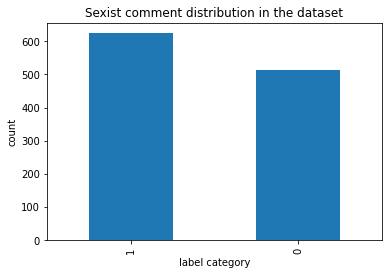

In [ ]:
df['Label'].value_counts().plot(kind='bar')
plt.xlabel('label category')
plt.ylabel('count')
plt.title('Sexist comment distribution in the dataset')
plt.show()

## Train-test split

In [ ]:
X = df[['Sentences']]
y = df.Label
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state = 66, stratify=y)

In [ ]:
#!unzip '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-GNGloVe-300d-0.8-0.8.zip' -d '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/'

### Loading the Gender neutral GLoVe embedding

In [ ]:
def read_glove_vecs(glove_file):
    with open(glove_file, encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

In [ ]:
embedding_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/Embeddings/1b-vectors300-0.8-0.8.txt'
words_to_index, index_to_words, word_to_vec_map = read_glove_vecs(embedding_path)

In [ ]:
word_to_vec_map['and'].shape

(300,)

In [ ]:
vocab = list(words_to_index.keys())

In [ ]:
len(vocab)

142527

### Getting word embeddigs for the input data - X_train and X_test

In [ ]:
def get_tokens_embedding_list(data, vocab, word_to_vec_map):
  embedding_list = []
  for sent_seq in data:
    tensor_list=[]
    for word in sent_seq[0].split():
      if word in vocab:
        tensor_list.append(word_to_vec_map[word])
        # print(len(tensor_list))
    embedding_list.append(tensor_list)
  return embedding_list

In [ ]:
X_train_embedding = get_tokens_embedding_list(X_train.values, vocab, word_to_vec_map)
X_test_embedding = get_tokens_embedding_list(X_test.values, vocab, word_to_vec_map)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_embedding, y_train, train_size=0.9, random_state=66)

In [ ]:
len(X_train_embedding), len(X_train), len(X_test_embedding)

(909, 818, 228)

In [ ]:
np.array(X_train[0]).shape

(15, 300)

In [ ]:
def create_dataset(data_in, target_in):
   
    #Get the length of each sentence
    N = [len(data_in[i]) for i, _ in enumerate(data_in)]
    embedding_size = 300
    tensor_N = tf.constant(N, tf.int32)
    ragged_input  = tf.ragged.constant(data_in, dtype=tf.float32)
    print(ragged_input.shape)

    # Build the dataset and the operations
    dataset = tf.data.Dataset.from_tensor_slices((ragged_input, target_in))
    del ragged_input

    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(32)
    
    # Transform_pad function is defined above; you can change the num_parallel_calls
    dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None, embedding_size]), y), num_parallel_calls=3)   
                          
    dataset = dataset.prefetch(1)
    return dataset

In [ ]:
train_dataset = create_dataset(X_train, y_train)
val_dataset = create_dataset(X_val, y_val)

(818, None, None)
(91, None, None)


In [ ]:
train_dataset

<PrefetchDataset shapes: ((None, None, 300), (None,)), types: (tf.float32, tf.int64)>

### Define the model

In [ ]:
input_layer = Input((None, 300), name='input')
bid_lstm_1 = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
dropout_1 = Dropout(0.5)(bid_lstm_1)
bid_lstm_2 = Bidirectional(LSTM(128, return_sequences=False))(dropout_1)
dropout_2 = Dropout(0.5)(bid_lstm_2)
dense = Dense(1, activation='sigmoid')(dropout_2)

model = Model(inputs=input_layer, outputs=dense)

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, None, 300)]       0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, None, 256)         439296    
_________________________________________________________________
dropout_6 (Dropout)          (None, None, 256)         0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 256)               394240    
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 833,793
Trainable params: 833,793
Non-trainable params: 0
_____________________________________________________

In [ ]:
model.compile(optimizer='adam', loss='bce', metrics=tfa.metrics.F1Score(num_classes=2, average='micro'))

In [ ]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset, verbose=1)

Epoch 1/10
26/26 [==============================] - ETA: 0s - loss: 0.5777 - f1_score: 0.7077

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


26/26 [==============================] - 9s 117ms/step - loss: 0.5777 - f1_score: 0.7077 - val_loss: 0.6957 - val_f1_score: 0.7183
Epoch 2/10
26/26 [==============================] - 1s 45ms/step - loss: 0.4334 - f1_score: 0.7077 - val_loss: 0.4260 - val_f1_score: 0.7183
Epoch 3/10
26/26 [==============================] - 1s 44ms/step - loss: 0.3461 - f1_score: 0.7077 - val_loss: 0.4095 - val_f1_score: 0.7183
Epoch 4/10
26/26 [==============================] - 1s 45ms/step - loss: 0.3106 - f1_score: 0.7077 - val_loss: 0.3663 - val_f1_score: 0.7183
Epoch 5/10
26/26 [==============================] - 1s 43ms/step - loss: 0.2468 - f1_score: 0.7077 - val_loss: 0.4138 - val_f1_score: 0.7183
Epoch 6/10
26/26 [==============================] - 1s 45ms/step - loss: 0.1977 - f1_score: 0.7077 - val_loss: 0.4269 - val_f1_score: 0.7183
Epoch 7/10
26/26 [==============================] - 1s 45ms/step - loss: 0.1496 - f1_score: 0.7077 - val_loss: 0.4332 - val_f1_score: 0.7183
Epoch 8/10
26/26 [=====

In [ ]:
ragged_input_test  = tf.ragged.constant(X_test_embedding, dtype=tf.float32)
dataset = tf.data.Dataset.from_tensor_slices((ragged_input_test, y_test))
dataset = dataset.shuffle(1000)
dataset = dataset.batch(1)
test_dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None, 300]),y), num_parallel_calls=3)


In [ ]:
loss, f_score = model.evaluate(test_dataset)

 26/228 [==>...........................] - ETA: 1s - loss: 0.7006 - f1_score: 0.7619

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/metrics.py:257: UserWarning: Metric F1Score implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  'consistency.' % (self.__class__.__name__,))


228/228 [==============================] - 1s 6ms/step - loss: 0.6416 - f1_score: 0.7082


### Script to get the data for everyday Sexism project

In [5]:
!pip install ipdb

     |████████████████████████████████| 788kB 2.8MB/s 
     |████████████████████████████████| 368kB 4.3MB/s 
  Created wheel for ipdb: filename=ipdb-0.13.8-cp37-none-any.whl size=11599 sha256=95a0559d4a565e0a5640b0fd030a31d73680ffbf4458b9e18ba5b1590c7cd94e
  Stored in directory: /root/.cache/pip/wheels/0d/d6/5a/2fdf30b75ca5099e18f66a0a4d439ba031e1aa239e12b39c24
Successfully built ipdb
ERROR: jupyter-console 5.2.0 has requirement prompt-toolkit<2.0.0,>=1.0.0, but you'll have prompt-toolkit 3.0.18 which is incompatible.
ERROR: google-colab 1.0.0 has requirement ipython~=5.5.0, but you'll have ipython 7.23.1 which is incompatible.
  Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      Successfully uninstalled prompt-toolkit-1.0.18
  Found existing installation: ipython 5.5.0
    Uninstalling ipython-5.5.0:
      Successfully uninstalled ipython-5.5.0


In [3]:
!apt-get install libmagic-dev
!pip install python-magic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libmagic-mgc libmagic1
Suggested packages:
  file
The following NEW packages will be installed:
  libmagic-dev libmagic-mgc libmagic1
0 upgraded, 3 newly installed, 0 to remove and 34 not upgraded.
Need to get 332 kB of archives.
After this operation, 5,552 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-mgc amd64 1:5.32-2ubuntu0.4 [184 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic1 amd64 1:5.32-2ubuntu0.4 [68.6 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 libmagic-dev amd64 1:5.32-2ubuntu0.4 [79.7 kB]
Fetched 332 kB in 2s (191 kB/s)
Selecting previously unselected package libmagic-m

In [4]:
!pip install ftfy

     |████████████████████████████████| 71kB 2.0MB/s 
  Created wheel for ftfy: filename=ftfy-6.0.3-cp37-none-any.whl size=41916 sha256=f1391e25c234d93bcd6ebe25c26ed7fbbdb4abcaab4913fda78e7c256b03d135
  Stored in directory: /root/.cache/pip/wheels/99/2c/e6/109c8a28fef7a443f67ba58df21fe1d0067ac3322e75e6b0b7
Successfully built ftfy


In [12]:
# Example use: python script.py data_placeholders.tsv data.tsv
import re
import urllib.request as urllib2
import os
import ipdb
from bs4 import BeautifulSoup
import time
import sys
import codecs
import pandas as pd
import csv
import json
from os import listdir
from os.path import isfile, join
import io
import magic
import pickle
import ftfy

tsv_filepath = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/Everyday Sexism Project/data_placeholders.tsv'
data_write_path = '/content/drive/MyDrive/UnivAI/AI-3 Project/data/Everyday Sexism Project/data.tsv'


def find_post_id(name_box):
    classes = name_box['class']
    for _class in classes:
        if _class[:5] == "post-" and len(_class) > 5:
            return int(_class[5:])
    return -1


def crawl_post(post_page, post_number):
    crawl_page = post_page + str(post_number)

    isCrawledSuccessfully = False
    while not isCrawledSuccessfully:
        try:
            page = urllib2.urlopen(crawl_page).read()
            isCrawledSuccessfully = True
        except urllib2.HTTPError as e:
            if e.code == 404:
                print("\t\t>>> Found 404")
                return None
            else:
                print("\t\t>>> Waitiing for 30 seconds")
                time.sleep(30)
        except Exception:
            print("\t\t>>> Waitiing for 30 seconds")
            time.sleep(30)

    soup = BeautifulSoup(page, 'html.parser')
    name_boxes = soup.find_all('article', attrs={'class': 'post'})
    assert len(name_boxes) == 1
    for i, name_box in enumerate(name_boxes):
        post_id = find_post_id(name_box)
        if post_id == -1:
            print("\t\t>>> ERROR: Error fetching post_id")
            return None
        
        #TODO: VERIFY IF THIS IS CORRECT
        soup = BeautifulSoup(name_box.encode("utf-8"), 'html.parser')
        _name_box = soup.find('div', attrs={'class': 'entry-content'})
        post = _name_box.get_text()
        post = post.replace('\n', '<br/>')
    return post


import re

r_white = re.compile(r'\s+')

xml_csv = open(data_write_path, 'w')
csv_writer = csv.writer(xml_csv, delimiter='\t')
csv_writer.writerow(['post', 'labels'])

post_id_dict = {}

with open(tsv_filepath, 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter='\t')
    for i, row in enumerate(spamreader):
        if i == 0:
            continue
        labels = row[1]
        parts = row[0].split("__")
        post_id__str = parts[0]
        post_offsets__str = [offset.split("_") for offset in parts[1:]]

        if post_id__str in post_id_dict:
            print("accessing " + post_id__str)
            post_text = post_id_dict[post_id__str]
        else:
            print("fetching " + post_id__str)
            post_text = crawl_post("https://everydaysexism.com/everyday-sexism/", post_id__str)
            if post_text == None:
                continue
            post_id_dict[post_id__str] = post_text

        post_text = post_text.replace('<br/>', ' ')
        post_text = re.sub(' +', ' ', post_text)
        post_text = post_text.lstrip()
        post_text__fixed = ftfy.fix_text(post_text)
        text = ""
        for index in range(len(post_offsets__str)):
            text = text + post_text__fixed[int(post_offsets__str[index][0]):int(post_offsets__str[index][1]) + 1]
            if len(post_offsets__str) > 1 and len(post_offsets__str) != index + 1:
                text = text + " "
        text = r_white.sub(' ', text)
        text = text.strip()
        csv_writer.writerow([text, labels])

xml_csv.close()

Streaming output truncated to the last 5000 lines.
fetching 32613
fetching 117638
fetching 73241
fetching 117635
fetching 73234
fetching 73232
fetching 181401
fetching 32591
fetching 73227
fetching 32586
fetching 73225
fetching 73207
fetching 32584
fetching 181406
fetching 181410
fetching 73195
fetching 73191
fetching 32567
fetching 88958
fetching 88955
fetching 88938
fetching 32560
fetching 32558
fetching 88931
fetching 88926
fetching 88923
fetching 111771
fetching 55465
fetching 55461
fetching 111770
fetching 111763
fetching 55425
fetching 175698
accessing 175698
accessing 175698
fetching 175704
accessing 175704
fetching 175711
fetching 175712
fetching 175715
fetching 111735
fetching 175717
fetching 175721
fetching 111724
fetching 111722
accessing 111722
accessing 111722
fetching 84755
fetching 113526
fetching 157875
fetching 157877
fetching 24040
fetching 111158
fetching 24036
fetching 175683
fetching 157883
fetching 111157
fetching 111155
fetching 157896
fetching 175681
fetching 66

In [13]:
df_es = pd.read_csv(data_write_path, sep='\t')